In [41]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch.optim.lr_scheduler as lr_sch

In [56]:
here = Path.home() / Path('Desktop\Jupyter_Notebook\Projects\emotion_detection\\face_detection')
print(here)
os.chdir(here)

C:\Users\Dustin Baek\Desktop\Jupyter_Notebook\Projects\emotion_detection\face_detection


In [57]:
#Using old version: os.
# path =Path.cwd()

path = '../archive/fer2013'
print(path)
print(os.listdir(path))

# print(path.parent)

../archive/fer2013
['fer2013.bib', 'fer2013.csv', 'README', 'train', 'validation']


In [58]:
#Using new version: pathlib
path = Path.cwd()
path = path.parent/ 'archive/fer2013'
# print(list(path))
classes_train = path / 'train'
classes_valid = path / 'validation'
if classes_train.exists():
    print('it exists')
list(classes_train.iterdir())
list(classes_valid.iterdir())
#or can use .glob()
list(classes_train.glob('*'))

it exists


[WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Angry'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Disgust'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Fear'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Happy'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Neutral'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Sad'),
 WindowsPath('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/Projects/emotion_detection/archive/fer2013/train/Surprise')]

In [59]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])
#                          tt.Normalize((0.507395516207, ),(0.255128989415, ))])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])
#                         tt.Normalize((0.507395516207, ),(0.255128989415, ))])

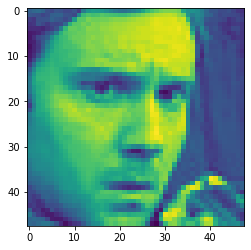

In [60]:
image_check = classes_train/'Angry'/'0.jpg'
img = Image.open(image_check)
plt.imshow(np.asarray(img))

In [61]:
import collections

In [62]:
image_num = image_check.parent.parent
image_angry = image_num / 'Angry'
len(list(image_angry.iterdir()))
# for i in classes_train.glob('*'):
#     print(len(i))
for p in classes_train.iterdir():
    jpg = collections.Counter(a.suffix for a in p.iterdir())
    print(f'Emotion:{p.name}, Number of {p.name} images:{jpg}')
# collections.Counter(p for p in classes_train.iterdir())

Emotion:Angry, Number of Angry images:Counter({'.jpg': 3995})
Emotion:Disgust, Number of Disgust images:Counter({'.jpg': 436})
Emotion:Fear, Number of Fear images:Counter({'.jpg': 4097})
Emotion:Happy, Number of Happy images:Counter({'.jpg': 7215})
Emotion:Neutral, Number of Neutral images:Counter({'.jpg': 4965})
Emotion:Sad, Number of Sad images:Counter({'.jpg': 4830})
Emotion:Surprise, Number of Surprise images:Counter({'.jpg': 3171})


In [64]:
3995+436+4097+7215+4965+4830+3171

28709

In [65]:
train_data = ImageFolder(root = classes_train, transform = train_tfms)
valid_data = ImageFolder(root = classes_valid, transform = valid_tfms)

In [66]:
batch = 200

In [67]:
train_set = DataLoader(dataset = train_data, batch_size = batch, shuffle =True, num_workers=3, pin_memory=True )
valid_set = DataLoader(dataset = valid_data, batch_size = batch, shuffle =True, num_workers=3, pin_memory=True )

In [68]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        print(len(images))
        print(labels[0])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])
200
tensor(6)


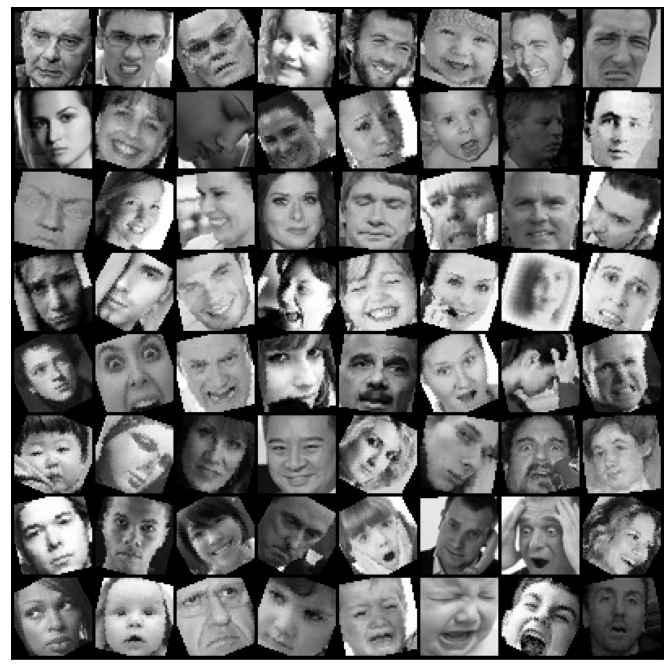

In [69]:
show_batch(train_set)


In [70]:
len(train_set)

144

In [71]:
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [72]:
'''Model'''

class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.cnn1_bn = nn.BatchNorm2d(8)
        self.cnn2_bn = nn.BatchNorm2d(16)
        self.cnn3_bn = nn.BatchNorm2d(32)
        self.cnn4_bn = nn.BatchNorm2d(64)
        self.cnn5_bn = nn.BatchNorm2d(128)
        self.cnn6_bn = nn.BatchNorm2d(256)
        self.cnn7_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
        x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
        x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
        x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
        x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
        x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
        x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.dropoutpout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.log_softmax(self.fc3(x))
        return x

In [73]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [74]:
model = ResNet(1,len(list(image_num.iterdir())))
model.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [75]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)

In [76]:
'''Train Model'''
def train_model(model, epochs, train_set, valid_set, max_lr):
    train_loss=[]
    valid_loss=[]
    valid_acc_list=[]
    patience=0
    
#     scheduler = lr_sch.CosineAnnealingLR(optimizer, len(train_set))
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_set))    

    scheduler = lr_sch.StepLR(optimizer, step_size=3, gamma=0.92) 
    
    for epoch in range(epochs):
        model.train()
        running_loss=0
        correct=0
        total=0
        
        valid_running_loss=0
        correct_valid=0
        total_valid=0
        for i, data in enumerate(train_set,1):
            image, label = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            running_loss+= loss.item()
            
            pred=output.data.max(1,keepdim=True)[1]
            correct+=sum(pred.eq(label.data.view_as(pred)))
            total+= label.size(0)
            
            ####for one cycleLR step is implemented in this loop
#             scheduler.step()
            
        train_accuracy = 100. * float(correct) / total
        train_loss.append(running_loss/len(train_set))
        
        
        model.eval() # prep model for evaluation
        with torch.no_grad():    
            for data in valid_set:
                inputs,target = data[0].to(device), data[1].to(device)
                output = model(inputs)
                loss = criterion(output, target)
                
                valid_running_loss+=loss.item()
                
                pred=output.data.max(1,keepdim=True)[1]
                correct_valid+=sum(pred.eq(target.data.view_as(pred)))
                total_valid+= target.size(0)
        valid_accuracy = 100 * float(correct_valid) / total_valid
        valid_loss.append(valid_running_loss/(len(valid_set)))
        valid_acc_list.append(valid_accuracy)
        print_msg = (f'Epochs: {epoch} in {epochs} ' + f'Train_Loss: {train_loss[-1]: .3f} ' + 
              f'Train_Accuracy: {train_accuracy: .3f}% ' + f'Valid_Loss:{valid_loss[-1]: .3f} ' +
                     f'Valid_Accuracy: {valid_accuracy: .3f}% '+ f"LR: {optimizer.param_groups[0]['lr']}")
        print(print_msg)
        print('\n')
        
        scheduler.step()
        if patience == 10:
            model.load_state_dict(torch.load('best_model.pt'))
            break
        else:
            if len(valid_acc_list)>=2:
                if valid_acc_list[-1] != max(valid_acc_list):
                    patience+=1
                else:
                    patience=0
                    torch.save(model.state_dict(), 'best_model.pt')
                    print(f'Valication Accuracy Increased {valid_acc_list[-2]: .3f} --> {valid_acc_list[-1]: .3f}.\
                    Saving model...')
                    continue
        
        

In [77]:
epochs = 100
max_lr = 0.008
train_model(model, epochs, train_set, valid_set, max_lr)

Epochs: 0 in 100 Train_Loss:  2.010 Train_Accuracy:  23.860% Valid_Loss: 1.802 Valid_Accuracy:  25.355% LR: 0.001


Epochs: 1 in 100 Train_Loss:  1.743 Train_Accuracy:  29.465% Valid_Loss: 1.798 Valid_Accuracy:  25.160% LR: 0.001


Epochs: 2 in 100 Train_Loss:  1.668 Train_Accuracy:  33.996% Valid_Loss: 1.946 Valid_Accuracy:  27.361% LR: 0.001


Valication Accuracy Increased  25.160 -->  27.361.                    Saving model...
Epochs: 3 in 100 Train_Loss:  1.561 Train_Accuracy:  39.127% Valid_Loss: 1.603 Valid_Accuracy:  35.832% LR: 0.00092


Valication Accuracy Increased  27.361 -->  35.832.                    Saving model...
Epochs: 4 in 100 Train_Loss:  1.500 Train_Accuracy:  41.534% Valid_Loss: 1.573 Valid_Accuracy:  38.144% LR: 0.00092


Valication Accuracy Increased  35.832 -->  38.144.                    Saving model...
Epochs: 5 in 100 Train_Loss:  1.426 Train_Accuracy:  44.993% Valid_Loss: 1.488 Valid_Accuracy:  44.023% LR: 0.00092


Valication Accuracy Increased  38.144 --

Epochs: 51 in 100 Train_Loss:  0.839 Train_Accuracy:  68.668% Valid_Loss: 1.221 Valid_Accuracy:  57.732% LR: 0.0002423221228050216


Epochs: 52 in 100 Train_Loss:  0.828 Train_Accuracy:  69.156% Valid_Loss: 1.219 Valid_Accuracy:  57.119% LR: 0.0002423221228050216


Epochs: 53 in 100 Train_Loss:  0.822 Train_Accuracy:  69.254% Valid_Loss: 1.245 Valid_Accuracy:  58.651% LR: 0.0002423221228050216


Valication Accuracy Increased  57.119 -->  58.651.                    Saving model...
Epochs: 54 in 100 Train_Loss:  0.814 Train_Accuracy:  69.672% Valid_Loss: 1.223 Valid_Accuracy:  57.230% LR: 0.00022293635298061988


Epochs: 55 in 100 Train_Loss:  0.805 Train_Accuracy:  69.919% Valid_Loss: 1.218 Valid_Accuracy:  57.091% LR: 0.00022293635298061988


Epochs: 56 in 100 Train_Loss:  0.802 Train_Accuracy:  70.180% Valid_Loss: 1.223 Valid_Accuracy:  57.147% LR: 0.00022293635298061988


Epochs: 57 in 100 Train_Loss:  0.786 Train_Accuracy:  70.758% Valid_Loss: 1.217 Valid_Accuracy:  57.119% LR: 0.00

In [78]:
'''Test Model'''
def test_model(model, image):
    
    model.load_state_dict(torch.load('best_model.pt'))

    model.eval()
    model.to(device)
    with torch.no_grad():
        image = torch.Tensor(image)
        image = image.to(device)
        output = model(image)
        pred=output.data.max(1,keepdim=True)[1]
    
    return pred

    

In [79]:
Path.cwd()
change_path = Path('C:/Users/Dustin Baek/Desktop/Jupyter_Notebook/OpenCV/Resources')
os.chdir(change_path)

In [80]:
'''Real-Time Emotion Detection OpenCV'''
import cv2
import os

emotion = {0: "Angry", 1: "Disgust", 2: "Fear", 3:"Happy", 4: "Neutral", 5: "Sad", 6: "Surprise" }

path = "opencv_master/data/haarcascades/haarcascade_frontalface_default.xml"
# os.chdir(face_path)

cap = cv2.VideoCapture(0)

while(cap.isOpened()):
    ret,frame = cap.read()

#         cv2.imshow('camera',frame)
    if ret == True:
        faceCascade = cv2.CascadeClassifier(path)
        imgGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(imgGray, 1.2,5)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 3)
            
            ###From here we have to input cropped image of real-time detected face into our model
            ###Use gray image with resized sahpe to 48 by 48
            roi_gray = imgGray[y:y+h,x:x+w]
            resized_input = cv2.resize(roi_gray, (48,48))
            
            ##add dimension to give 1x1x48x48
            input_to_model = np.expand_dims(np.expand_dims(resized_input,0) , 0)
            prediction = test_model(model, input_to_model)
            
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = cv2.putText(frame, emotion[prediction.item()], (x+20,y-60), font, 3, (255,255,255), 3, cv2.LINE_AA)

        cv2.imshow('emotion detector', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("camera not accessible")
        break
cap.release()
cv2.destroyAllWindows()


